In [1]:
from string import punctuation
from nltk.corpus import stopwords
import requests
import json
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
from string import punctuation
import string
import re
from langdetect import detect, LangDetectException
import math
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.util import ngrams
from collections import Counter

api_key = "9b38cabe85mshb282f035a7bb13cp1fce86jsnc1693aca1d59"

In [2]:
# Get the function_words
function_words = json.loads(urlopen(
    "https://raw.githubusercontent.com/bachdumpling/genz-dictionary-model/main/function_words.json").read())

# Get the stopwords and punctuation
nltk.download('stopwords')

stopwords = set(stopwords.words('english'))

punctuation = list(punctuation)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bachdumpling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [150]:
comment_data = pd.read_csv("english_comments1.csv", on_bad_lines='skip')

# raw_comments = comment_data["comments"].tolist()
dirty_comments = comment_data["comments"].tolist()

#clean:
comments = []
for comment in dirty_comments:
    comment = re.sub(r'[^\w\s]', '', comment)
    comment = remove_emoji(comment)
    print(comment)
    comments.append(comment)


print(comments)
print(len(comments))

having a manager under 30 i good bc you can have an actual conversation with them
me the shift leader omw up to that register at 16 ready to gaslight customers and not let them get away with anything
im 18 fruity and a manager at my job Had a lady request corporate on me yesterday 
Me when I was a manager for subway
Let me speak to your manager Someone younger then them walks out them 
Why couldnt I have had that at Starbucks or Dunkin  Just old hags who wanted to be corporate
Thats the best kind of supervisor
Im a manager at 18 and i dont be letting these petty customers have they way
mangers under like 23 are the best bc theyre not gonna give the customer what they want and they will talk back
Happy birthday manager
AhhhI miss the Timmies crew
Happy birthday and w manager
Annabeth chase duup 
happy birthday supervisor
Ngl the fruity supervisor with attitude thats still in HS would be TERRIFYING 
but using Adobe podcast 
Keeping up w the speed of AI updates is exhausting
Going through

In [163]:
def train_unigram_model(corpus):
    words = [word.lower() for sentence in corpus for word in word_tokenize(sentence)]
    unigram_freq = Counter(words)
    return unigram_freq

def train_bigram_model(corpus):
    words = [word.lower()
             for sentence in corpus for word in word_tokenize(sentence)]
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(4)
    scored_bigrams = finder.score_ngrams(bigram_measures.pmi)
    return dict(scored_bigrams)

unigram_model = train_unigram_model(comments)
bigram_model = train_bigram_model(comments)
print(bigram_model)

def calculate_combinations(cleaned_tokens, unigram_model, bigram_model, unigram_threshold, bigram_threshold):
    filtered_combinations = []

    for i in range(len(cleaned_tokens)):
        for j in range(i+1, len(cleaned_tokens)+1):
            if j - i == 2:  # Bigram case
                bigram = tuple(cleaned_tokens[i:j])
                # print(" ".join(bigram))
                if bigram in bigram_model:
                    bigram_pmi = bigram_model[bigram]
                    print("bigram:", bigram, bigram_pmi)
                    if bigram_pmi > bigram_threshold:
                        filtered_combinations.append(" ".join(bigram))
                        # print(" ".join(bigram))
            # if j - i == 1:  # Unigram case
            #     unigram = cleaned_tokens[i]
            #     unigram_freq = unigram_model.get(unigram, 0)
            #     if unigram_freq <= unigram_threshold:
            #         filtered_combinations.append(unigram)
    print(filtered_combinations)
    return filtered_combinations

def idf(word, comments):
    num_docs_with_word = sum(
        1 for comment in comments if word in comment.lower())
    return math.log(len(comments) / (1 + num_docs_with_word))
    

{('bruno', 'mars'): 14.76022094646651, ('digital', 'footprint'): 14.76022094646651, ('edward', 'robinson'): 14.76022094646651, ('vp', 'shunt'): 14.76022094646651, ('charlie', 'puth'): 14.497186540632717, ('elon', 'musk'): 14.497186540632715, ('pastor', 'jeff'): 14.497186540632715, ('conga', 'conga'): 14.438292851579149, ('tractor', 'supply'): 14.438292851579149, ('plot', 'twist'): 14.175258445745353, ('james', 'charles'): 14.082149041353873, ('morgan', 'freeman'): 14.08214904135387, ('gender', 'reveal'): 14.011759713462475, ('gen', 'surg'): 13.91222403991156, ('mulch', 'glue'): 13.91222403991156, ('toxic', 'trait'): 13.68983161857511, ('taco', 'bell'): 13.497186540632717, ('epi', 'pen'): 13.497186540632715, ('san', 'antonio'): 13.497186540632715, ('tik', 'tok'): 13.48521389896664, ('messy', 'bun'): 13.467439197238665, ('auntie', 'nae'): 13.304541462690318, ('spicy', 'mayo'): 13.300789327829213, ('pizza', 'planet'): 13.175258445745353, ('neon', 'lights'): 13.104869117853955, ('aperol', 

In [180]:
bigram_threshold = 12
unigram_threshold = 20

result = []

def combo(sentence, comments):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    sentence = remove_emoji(sentence)

    duplicated_tokens = word_tokenize(sentence)
    tokens = list(set(duplicated_tokens))

    cleaned_tokens = [
        token.lower()
        for token in tokens
        if token.lower() not in stopwords
        and token.lower() not in function_words
        and token.lower() not in punctuation
    ]

    # print(cleaned_tokens)

    combinations = calculate_combinations(
        cleaned_tokens, unigram_model, bigram_model, unigram_threshold, bigram_threshold)
    
    top_words = [word for word in combinations]
    result.append(top_words)

for comment in comments:
    combo(comment, comments)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
bigram: ('happy', 'birthday') 8.930371386621818
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
bigram: ('think', 'im') 2.3510952360011927
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
bigram: ('bro', 'got') 4.028901915441445
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
bigram: ('come', 'back') 6.545616115190329
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
bigram: ('sams', 'club') 12.76022094646651
['sams club']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[('magic trick', 5), ('reusable toilet', 5), ('secret shopper', 4), ('taylor swift', 3), ('eid mubarak', 3), ('morgan freeman', 3), ('james charles', 3), ('neon lights', 3), ('cleaning fee', 3), ('sams club', 2), ('toxic trait', 2), ('vp shunt', 2), ('epi pen', 1), ('san antonio', 1), ('digital footprint', 1), ('master switches', 1), ('passenger seat', 1), ('pastor jeff', 1), ('taco bell', 1)]


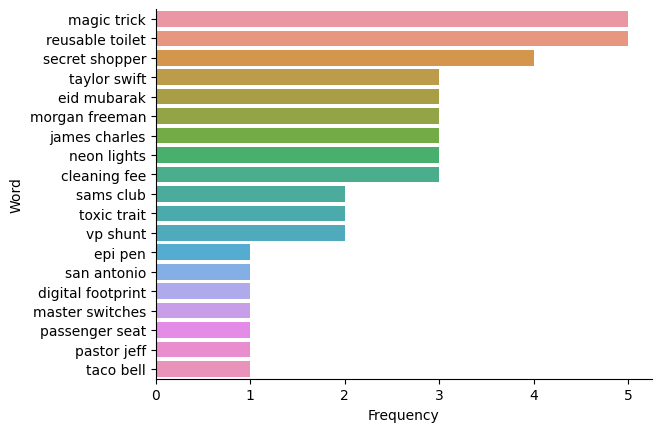

['sams club', 'toxic trait', 'taylor swift', 'magic trick', 'magic trick', 'epi pen', 'eid mubarak', 'morgan freeman', 'eid mubarak', 'vp shunt', 'vp shunt', 'san antonio', 'secret shopper', 'secret shopper', 'secret shopper', 'secret shopper', 'reusable toilet', 'reusable toilet', 'magic trick', 'magic trick', 'magic trick', 'taylor swift', 'digital footprint', 'eid mubarak', 'reusable toilet', 'reusable toilet', 'reusable toilet', 'master switches', 'toxic trait', 'james charles', 'james charles', 'james charles', 'passenger seat', 'pastor jeff', 'sams club', 'taco bell', 'neon lights', 'neon lights', 'neon lights', 'morgan freeman', 'morgan freeman', 'taylor swift', 'cleaning fee', 'cleaning fee', 'cleaning fee']
[('sams club', 8.042249379538013), ('epi pen', 8.042249379538013), ('secret shopper', 8.042249379538013), ('master switches', 8.042249379538013), ('james charles', 8.042249379538013), ('passenger seat', 8.042249379538013), ('neon lights', 8.042249379538013), ('cleaning fee'

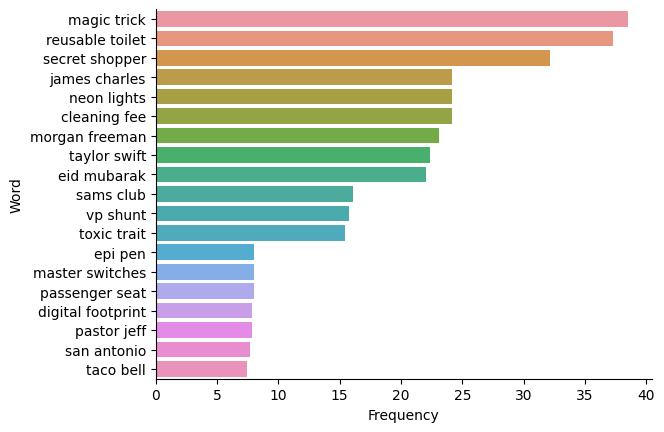

In [181]:
# Define a function to visualize the top words in a frequency distribution
def visualize_top_words(fdist, top_n=10):
    # Create a DataFrame with the top_n words and their frequencies
    df = pd.DataFrame(fdist.most_common(top_n), columns=['Word', 'Frequency'])
    
    # Check if the DataFrame is empty
    if df.empty:
        print("No top words found.")
    else:
        # Create a horizontal bar plot of the top words and their frequencies
        sns.barplot(data=df, x='Frequency', y='Word')
        # Remove the top and right spines of the plot for a cleaner appearance
        sns.despine()
        # Display the generated plot
        plt.show()

# Flatten the nested list 'result'
flat_result = []
for sublist in result:
    for item in sublist:
        flat_result.append(item)

# Create a frequency distribution from the flattened list
freq_dist = FreqDist(flat_result)

# Print and visualize the 10 most common words in the frequency distribution
print(freq_dist.most_common(20))
visualize_top_words(freq_dist, 20)

# Print the flattened list
print(flat_result)

# Calculate the IDF values for each word in the flattened list
idf_values = {}
for word in flat_result:
    if word not in idf_values:
        idf_values[word] = idf(word, comments)

# Sort the IDF values in descending order
sorted_idf_values = sorted(idf_values.items(), key=lambda x: x[1], reverse=True)

# Print the sorted IDF values
print(sorted_idf_values)

# Create an IDF-weighted frequency distribution
idf_weighted_freq_dist = FreqDist({word: freq * idf_values[word] for word, freq in freq_dist.items()})

# Print and visualize the 20 most common words in the IDF-weighted frequency distribution
print(idf_weighted_freq_dist.most_common(20))
visualize_top_words(idf_weighted_freq_dist, 20)